In [18]:
import numpy as np # importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import glob
import os
import astropy 
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
%matplotlib inline

In [19]:
pic = r"C:\Users\exs177\OneDrive - University of Birmingham\Group Studies\*.fits"
pic_list = glob.glob(pic)

# ppm = u.def_unit('ppm') #for python to understand non-standard units - for example ppm
# u.add_enabled_units([ppm]) #this is not necessarily needed, it's just so we don't keep getting the warning at the bottom

tbl = Table.read(pic_list[0])
print(tbl.colnames)
# pic_tabl1 = tbl[['PICname', 'RAdeg', 'DEdeg', 'distance', 'edistance','Gmag', 'eGmag']] 
# print(pic_tabl1)

pic_tabl2 = tbl[['PICname', 'StarName', 'Gmag', 'Teff', 'Radius', 'Mass', 'distance', 'tPICplanetFlag', 'NSSFlag']]
print(pic_tabl2)

['PICid', 'PICname', 'StarName', 'RAdeg', 'eRAdeg', 'DEdeg', 'eDEdeg', 'pmRA', 'epmRA', 'pmDE', 'epmDE', 'pm', 'epm', 'Plx', 'ePlx', 'distance', 'edistance', 'Glon', 'Glat', 'posEpoch', 'refEpoch', 'posPropFlag', 'PlatoMagNCAM', 'ePlatoMagNCAM', 'PlatoMagFCAMb', 'ePlatoMagFCAMb', 'PlatoMagFCAMr', 'ePlatoMagFCAMr', 'Gmag', 'eGmag', 'BPmag', 'eBPmag', 'RPmag', 'eRPmag', 'Hpmag', 'eHpmag', 'Ksmag', 'eKsmag', 'AG', 'eAG', 'AKs', 'eAKs', 'EBPRP', 'eEBPRP', 'extStatus', 'VmagCalculated', 'eVmagCalculated', 'Teff', 'eTeff', 'Radius', 'eRadius', 'Mass', 'eMass', 'caseFlag', 'PICmainSourceFlagBOL', 'tPICsourceFlagNCAM_BOL', 'fgPICsourceFlag', 'cPICsourceFlag', 'scvPICsourceFlag', 'NSSFlag', 'qualityFlag', 'tPICplanetFlag', 'fgPICcPICvariabilityFlag', 'targetStatusFlag', 'BOLrandomSysNSRNCAM_T', 'BOLnCameraObsNCAM_T', 'BOLnCameraSatNCAM_T', 'tPICscientificRanking', 'scvPICscientificRanking', 'scientificPriority', 'scheduledTarget']
     PICname                StarName                  Gmag      

We have found necessary column names and now we will mask the values of the stars to find sun like stars. This is so we can make sure that the data simulation team can only use stars that are sun like but also have a nice range of sun like stars. We also need to find the edge stars, to make sure that the simulations actually work and the stars we've chosen are 'good' selections. 

In [20]:
#NOW CREATING INDEXES OF ALL THE NECESSARY FILTERS TO VISUALISE ON A SCATTER OF ALL THE PIC STARS OF INTEREST 
plt.style.use('dark_background')

indstarname = (pic_tabl2['StarName'] == 'Gaia DR3 4763906879239461632')
print((pic_tabl2[indstarname]))

#---------------------------------------------------------------------------------------------------
# BRIGHTEST AND DIMMEST STARS
briall_idx = np.argmin(pic_tabl2['Gmag'])
dimall_idx = np.argmax(pic_tabl2['Gmag'])

bright_star = {
    'Mass': float(pic_tabl2['Mass'][briall_idx]),
    'Gmag': float(pic_tabl2['Gmag'][briall_idx])
}

dim_star = {
    'Mass': float(pic_tabl2['Mass'][dimall_idx]),
    'Gmag': float(pic_tabl2['Gmag'][dimall_idx])
}

#---------------------------------------------------------------------------------------------------
# BINARY OR EXOPLANET HOST STARS
flags = {
    'binary': pic_tabl2['NSSFlag'] != 0,
    'exo': pic_tabl2['tPICplanetFlag'] != 0
}

stars_by_flag = {}
for key, mask in flags.items():
    stars_by_flag[key] = {
        'Mass': np.asarray(pic_tabl2['Mass'][mask], dtype=float),
        'Gmag': np.asarray(pic_tabl2['Gmag'][mask], dtype=float)
    }

#---------------------------------------------------------------------------------------------------
# NEARBY STARS BY DISTANCE
distance_bins = [0, 10, 20, 50]
stars_by_distance = {}
for i in range(len(distance_bins)):
    if i == len(distance_bins)-1:
        mask = pic_tabl2['distance'] > distance_bins[i]
        label = f'>{distance_bins[i]}pc'
    else:
        mask = (pic_tabl2['distance'] > distance_bins[i]) & (pic_tabl2['distance'] <= distance_bins[i+1])
        label = f'{distance_bins[i]}pc–{distance_bins[i+1]}pc'
    stars_by_distance[label] = {
        'Mass': np.asarray(pic_tabl2['Mass'][mask], dtype=float),
        'Gmag': np.asarray(pic_tabl2['Gmag'][mask], dtype=float)
    }

#---------------------------------------------------------------------------------------------------
# STAR CLASS BY Teff
star_classes = {
    'M': (2300, 3900),
    'K': (3900, 5300),
    'G': (5300, 6000),
    'F': (6000, 7300),
    'A': (7300, 10000),
    'B': (10000, 33000),
    'O': (33000, np.inf)
}

stars_by_class = {}
for cls, (low, high) in star_classes.items():
    mask = (pic_tabl2['Teff'] >= low) & (pic_tabl2['Teff'] < high)
    stars_by_class[cls] = {
        'Mass': np.asarray(pic_tabl2['Mass'][mask], dtype=float),
        'Gmag': np.asarray(pic_tabl2['Gmag'][mask], dtype=float)
    }

#---------------------------------------------------------------------------------------------------
# POPULATION DENSITY BY MASS
mass_bins = [(0.5,0.7), (0.7,0.9), (0.9,1.1), (1.1,1.3), (1.3,1.5)]
stars_by_mass = {}
for i, (low, high) in enumerate(mass_bins, 1):
    mask = (pic_tabl2['Mass'] >= low) & (pic_tabl2['Mass'] < high)
    stars_by_mass[f'mass{i}'] = {
        'Mass': np.asarray(pic_tabl2['Mass'][mask], dtype=float),
        'Gmag': np.asarray(pic_tabl2['Gmag'][mask], dtype=float)
    }

#---------------------------------------------------------------------------------------------------
# MASS AND STAR TYPE COMBINATIONS
type_bins = [(2300,3900), (3900,5300), (5300,6000), (6000,7300), (7300,10000)]
stars_mass_type = {}
for i, (low, high) in enumerate(type_bins, 1):
    mask = (pic_tabl2['Mass'] >= 0.5) & (pic_tabl2['Mass'] < 1.5) & (pic_tabl2['Teff'] >= low) & (pic_tabl2['Teff'] < high)
    stars_mass_type[f'type{i}'] = {
        'Mass': np.asarray(pic_tabl2['Mass'][mask], dtype=float),
        'Gmag': np.asarray(pic_tabl2['Gmag'][mask], dtype=float)
    }



C:\Users\exs177\AppData\Local\Temp\ipykernel_4800\2928090392.py:13: UserWarning: Warning: converting a masked element to nan.
  'Mass': float(pic_tabl2['Mass'][briall_idx]),


     PICname                StarName                  Gmag             Teff       ... distance tPICplanetFlag NSSFlag
                                                      mag               K         ...    pc                          
----------------- ---------------------------- ----------------- ---------------- ... -------- -------------- -------
PIC 2897515000003 Gaia DR3 4763906879239461632 4.563652628295214 6066.85060889769 ...  11.6944              0       3


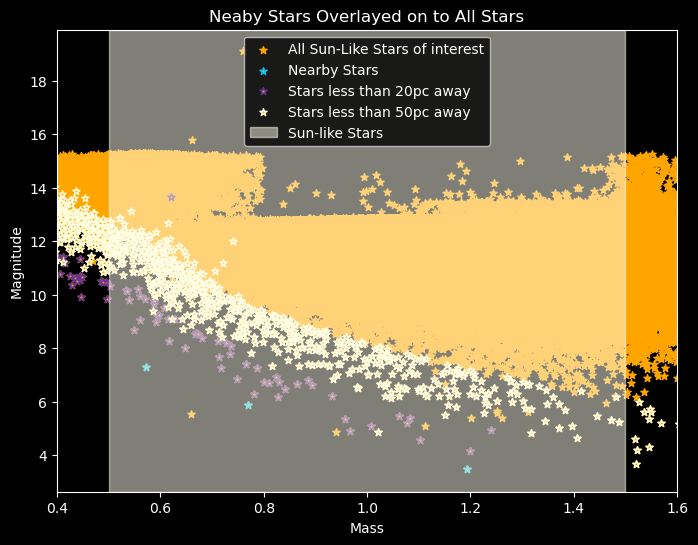

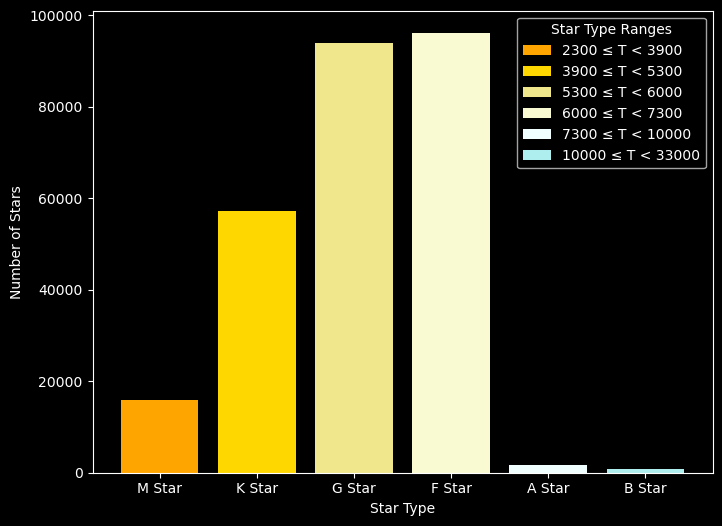

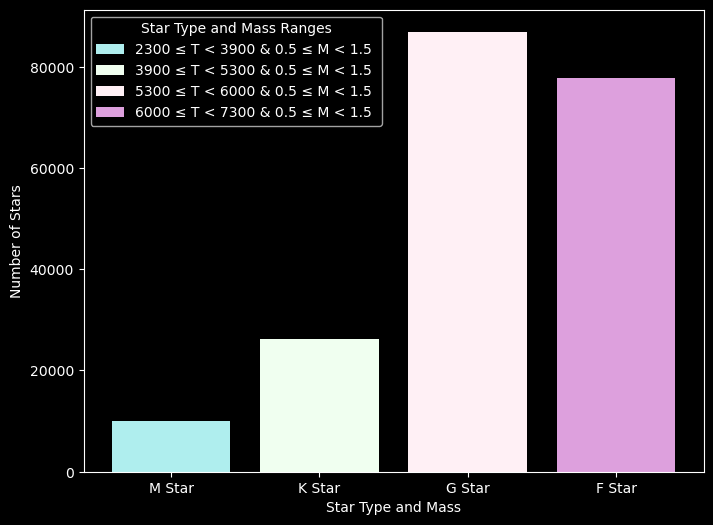

In [21]:
#NOW CREATING SCATTER GRAPHS OF ALL THE STARS AND STARS OF INTEREST

# plt.figure(figsize=(8,6))
# plt.scatter(pic_tabl2['Mass'], pic_tabl2['Gmag'], color = 'orange', s = 30, marker = '*', label = 'All Stars of interest')
# plt.scatter(Massallbri, briall, color = 'orange', edgecolor = 'darkcyan', linewidth = 1, s = 30, marker = '*', zorder = 3, label = 'Brightest Star')
# plt.scatter(Massalldim, dimall, color = 'orange', edgecolor = 'darkviolet', linewidth = 1, s = 30, marker = '*', zorder = 3, label = 'Dimmest Star')
# plt.scatter(Massallbin, Magbinall, color = 'orange', edgecolor = 'darkmagenta', linewidth = 1, s = 30, marker = '*', zorder = 3, label = 'Stars in Multi-Star Systems')
# plt.scatter(Massallexo, Magexoall, color = 'orange', edgecolor = 'lightyellow', linewidth = 1, s = 30, marker = '*', zorder = 3, label = 'Stars with Possible Exoplanets')
# plt.axvspan(0.5, 1.5, color='lavenderblush' , alpha=0.5, label = 'Sun-like Stars')
# plt.title('All stars in the Plato Input Catalogue')
# plt.xlabel('Mass')
# plt.ylabel('Magnitude')
# plt.legend()
# plt.show()

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# plt.figure(figsize=(8,6))
# plt.scatter(pic_tabl2['Mass'], pic_tabl2['Gmag'], color = 'orange', s = 30, marker = '*', label = 'All Stars of interest')
# plt.scatter(Massallbri, briall, color = 'orange', edgecolor = 'darkcyan', linewidth = 1, s = 30, marker = '*', zorder = 3, label = 'Brightest Star')
# plt.scatter(Massalldim, dimall, color = 'orange', edgecolor = 'darkviolet', linewidth = 1, s = 30, marker = '*', zorder = 3, label = 'Dimmest Star')
# plt.scatter(Massallbin, Magbinall, color = 'orange', edgecolor = 'darkmagenta', linewidth = 1, s = 30, marker = '*', zorder = 3, label = 'Stars in Multi-Star Systems')
# plt.scatter(Massallexo, Magexoall, color = 'orange', edgecolor = 'lightyellow', linewidth = 1, s = 30, marker = '*', zorder = 3, label = 'Stars with Possible Exoplanets')
# plt.axvspan(0.5, 1.5, color='lavenderblush' , alpha=0.5, label = 'Sun-like Stars')
# plt.xlim(0.4, 1.6)
# plt.title('All stars in the Plato Input Catalogue')
# plt.xlabel('Mass')
# plt.ylabel('Magnitude')
# plt.legend()
# plt.show()

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(8,6))
plt.scatter(pic_tabl2['Mass'], pic_tabl2['Gmag'], color = 'orange', s = 30, marker = '*', label = 'All Sun-Like Stars of interest')
plt.scatter(Massalldis, Magalldis, color = 'orange', edgecolor = 'deepskyblue', linewidth = 1, s = 30, marker = '*', label = 'Nearby Stars')
plt.scatter(Massalldis2, Magalldis2, color = 'orange', edgecolor = 'rebeccapurple', linewidth = 1, s = 30, marker = '*', label = 'Stars less than 20pc away')
plt.scatter(Massalldis3, Magalldis3, color = 'orange', edgecolor = 'lightyellow', linewidth = 1, s = 30, marker = '*', label = 'Stars less than 50pc away')
plt.axvspan(0.5, 1.5, color='ivory' , alpha=0.5, label = 'Sun-like Stars')
plt.xlim(0.4, 1.6)
plt.title('Neaby Stars Overlayed on to All Stars')
plt.xlabel('Mass')
plt.ylabel('Magnitude')
plt.legend()
plt.savefig('nearbystars1.jpeg')
plt.show()

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# plt.figure(figsize=(8,6))
# plt.scatter(MassMstar, MagMstar, color = 'orange', s = 30, marker = '*', label = 'M-Class Stars')
# plt.scatter(MassKstar, MagKstar, color = 'gold', s = 30, marker = '*', label = 'K-Class Stars')
# plt.scatter(MassGstar, MagGstar, color = 'khaki', s = 30, marker = '*', label = 'G-Class Stars')
# plt.scatter(MassFstar, MagFstar, color = 'lightgoldenrodyellow', s = 30, marker = '*', label = 'F-Class Stars')
# plt.scatter(MassAstar, MagAstar, color = 'azure', s = 30, marker = '*', label = 'A-Class Stars')
# plt.scatter(MassBstar, MagBstar, color = 'paleturquoise', s = 30, marker = '*', label = 'B-Class Stars')
# plt.axvspan(0.5, 1.5, color='white' , alpha=0.5, label = 'Sun-like Stars')
# plt.xlim(0.4, 1.6)
# plt.title('Star Classification')
# plt.xlabel('Mass')
# plt.ylabel('Magnitude')
# plt.legend()
# plt.show()

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


counts = [
    len(MassMstar),
    len(MassKstar),
    len(MassGstar),
    len(MassFstar),
    len(MassAstar),
    len(MassBstar)
         ]


legend_elements = [
    Patch(facecolor='orange', label='2300 ≤ T < 3900'),
    Patch(facecolor='gold', label='3900 ≤ T < 5300'),
    Patch(facecolor='khaki', label='5300 ≤ T < 6000'),
    Patch(facecolor='lightgoldenrodyellow', label='6000 ≤ T < 7300'),
    Patch(facecolor='azure', label='7300 ≤ T < 10000'),
    Patch(facecolor='paleturquoise', label='10000 ≤ T < 33000')
]


labels = ['M Star', 'K Star', 'G Star', 'F Star', 'A Star', 'B Star']

plt.figure(figsize=(8,6))
plt.bar(labels, counts, color=['orange', 'gold', 'khaki', 'lightgoldenrodyellow', 'azure', 'paleturquoise'])
plt.legend(handles=legend_elements, title="Star Type Ranges")
plt.ylabel('Number of Stars')
plt.xlabel('Star Type')
plt.savefig('startype.jpeg')
plt.show()
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# counts2 = [
#     len(Starmass1),
#     len(Starmass2),
#     len(Starmass3),
#     len(Starmass4),
#     len(Starmass5)
#          ]


# legend_elements2 = [
#     Patch(facecolor='cyan', label='0.5 ≤ M < 0.7'),
#     Patch(facecolor='lightcyan', label='0.7 ≤ M < 0.9'),
#     Patch(facecolor='lavender', label='0.9 ≤ M < 1.1'),
#     Patch(facecolor='lightpink', label='1.1 ≤ M < 1.3'),
#     Patch(facecolor='palevioletred', label='1.3 ≤ M < 1.5')
# ]


# labels2 = ['1', '2', '3', '4', '5']

# plt.figure(figsize=(8,6))
# plt.bar(labels2, counts2, color=['cyan','lightcyan','lavender','lightpink','palevioletred'])
# plt.legend(handles=legend_elements2, title="Star Mass Ranges")
# plt.ylabel('Number of Stars')
# plt.xlabel('Star Mass')
# plt.savefig('starmass.jpeg')
# plt.show()

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counts3 = [
    len(masstype1),
    len(masstype2),
    len(masstype3),
    len(masstype4)
         ]


legend_elements3 = [
    Patch(facecolor='paleturquoise', label='2300 ≤ T < 3900 & 0.5 ≤ M < 1.5 '),
    Patch(facecolor='honeydew', label='3900 ≤ T < 5300 & 0.5 ≤ M < 1.5'),
    Patch(facecolor='lavenderblush', label='5300 ≤ T < 6000 & 0.5 ≤ M < 1.5'),
    Patch(facecolor='plum', label='6000 ≤ T < 7300 & 0.5 ≤ M < 1.5'),
]


labels3 = ['M Star', 'K Star', 'G Star', 'F Star']

plt.figure(figsize=(8,6))
plt.bar(labels3, counts3, color=['paleturquoise', 'honeydew', 'lavenderblush', 'plum'])
plt.legend(handles=legend_elements3, title="Star Type and Mass Ranges")
plt.ylabel('Number of Stars')
plt.xlabel('Star Type and Mass')
plt.savefig('startypeandmass.jpeg')
plt.show()


# plt.figure(figsize=(8,6))
# plt.scatter(pictbl_clipped['Mass'], pictbl_clipped['Gmag'], color = 'hotpink', s = 30, marker = '*', label = 'All Stars')
# plt.scatter(Massbri, bri,color = 'hotpink', edgecolor = 'darkturquoise', linewidth = 1, marker = '*', s = 30, label = 'Brightest Star')
# plt.scatter(Massdim, dim,color = 'hotpink', edgecolor = 'lightyellow', linewidth = 1, marker = '*', s = 30, label = 'Dimmest Star')
# plt.scatter(binmass, binmag, color = 'hotpink', edgecolor = 'palegreen', linewidth = 1, s = 30, marker = '*', zorder = 3, label = 'Stars in multi-star system')
# plt.title('Mass against Magnitude of Stars Dimmer than 11 magnitudes')
# plt.xlabel('Mass(solar masses)')
# plt.ylabel('Magntidue(Mag)')
# plt.legend()
# plt.show()

In [22]:
# plt.figure(figsize=(8,6))
# plt.scatter(MassMstar, MagMstar, color = 'orange', s = 30, marker = '*', label = 'M-Class Stars')
# plt.axvspan(0.5, 1.5, color='white' , alpha=0.5, label = 'Sun-like Stars')
# plt.title('Star Classification')
# plt.xlabel('Mass')
# plt.ylabel('Magnitude')
# #plt.savefig('mstars.jepg')
# plt.legend()
# plt.show()

# #-----------------------------------------------------------------------------------------------------

# plt.figure(figsize=(8,6))
# plt.scatter(MassKstar, MagKstar, color = 'gold', s = 30, marker = '*', label = 'K-Class Stars')
# plt.axvspan(0.5, 1.5, color='white' , alpha=0.5, label = 'Sun-like Stars')
# plt.title('Star Classification')
# plt.xlabel('Mass')
# plt.ylabel('Magnitude')
# #plt.savefig('kstars.jpeg')
# plt.legend()
# plt.show()

# #-----------------------------------------------------------------------------------------------------

# plt.figure(figsize=(8,6))
# plt.scatter(MassGstar, MagGstar, color = 'khaki', s = 30, marker = '*', label = 'G-Class Stars')
# plt.axvspan(0.5, 1.5, color='white' , alpha=0.5, label = 'Sun-like Stars')
# plt.title('Star Classification')
# plt.xlabel('Mass')
# plt.ylabel('Magnitude')
# #plt.savefig('gstars.jpeg')
# plt.legend()
# plt.show()

# #-----------------------------------------------------------------------------------------------------

# plt.figure(figsize=(8,6))
# plt.scatter(MassFstar, MagFstar, color = 'lightgoldenrodyellow', s = 30, marker = '*', label = 'F-Class Stars')
# plt.axvspan(0.5, 1.5, color='white' , alpha=0.5, label = 'Sun-like Stars')
# plt.title('Star Classification')
# plt.xlabel('Mass')
# plt.ylabel('Magnitude')
# #plt.savefig('fstars.jpeg')
# plt.legend()
# plt.show()

# #-----------------------------------------------------------------------------------------------------

# plt.figure(figsize=(8,6))
# plt.scatter(MassAstar, MagAstar, color = 'azure', s = 30, marker = '*', label = 'A-Class Stars')
# plt.axvspan(0.5, 1.5, color='white' , alpha=0.5, label = 'Sun-like Stars')
# plt.title('Star Classification')
# plt.xlabel('Mass')
# plt.ylabel('Magnitude')
# plt.legend()
# plt.show()

# #-----------------------------------------------------------------------------------------------------

# plt.figure(figsize=(8,6))
# plt.scatter(MassBstar, MagBstar, color = 'paleturquoise', s = 30, marker = '*', label = 'B-Class Stars')
# plt.axvspan(0.5, 1.5, color='white' , alpha=0.5, label = 'Sun-like Stars')
# plt.title('Star Classification')
# plt.xlabel('Mass')
# plt.ylabel('Magnitude')
# plt.legend()
# plt.show()


NOW FOCUSING ON STARS WITHIN A SMALLER RANGE AND REFINING ANY OTHER DETAILS.

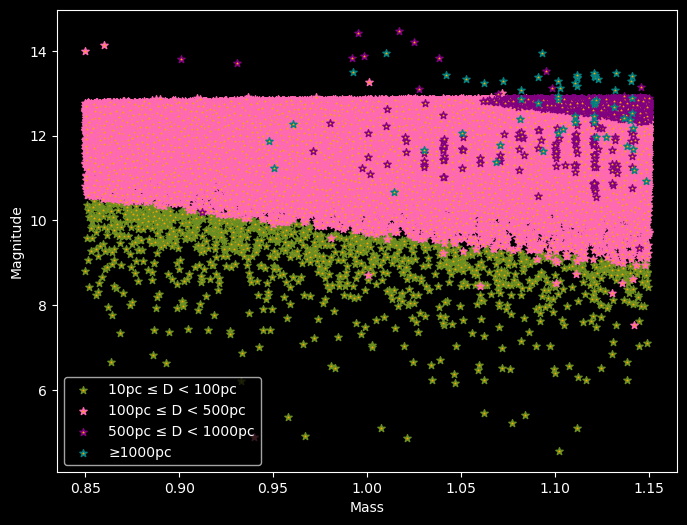

In [23]:

# Define mass filter
mass_mask = (pic_tabl2['Mass'] >= 0.85) & (pic_tabl2['Mass'] < 1.15)

# Define distance bins and labels
distance_bins = [0, 10, 100, 500, 1000, np.inf]
labels = ['<10pc', '10pc ≤ D < 100pc', '100pc ≤ D < 500pc', '500pc ≤ D < 1000pc', '≥1000pc']
edge_colors = ['paleturquoise', 'olivedrab', 'hotpink', 'purple', 'teal']

plt.figure(figsize=(8,6))

for i in range(len(distance_bins)-1):
    dist_mask = (pic_tabl2['distance'] >= distance_bins[i]) & (pic_tabl2['distance'] < distance_bins[i+1])
    mask = mass_mask & dist_mask
    
    mag = np.asarray(pic_tabl2['Gmag'][mask], dtype=float)
    mass = np.asarray(pic_tabl2['Mass'][mask], dtype=float)
    
    # Skip empty bins
    if len(mag) == 0:
        continue
    
    plt.scatter(mass, mag, color='orange', edgecolor=edge_colors[i], linewidth=1,
                s=30, marker='*', label=labels[i])


plt.xlabel('Mass')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

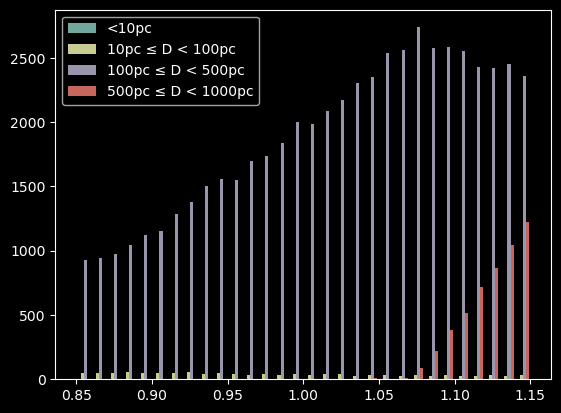

C:\Miniforge-all\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


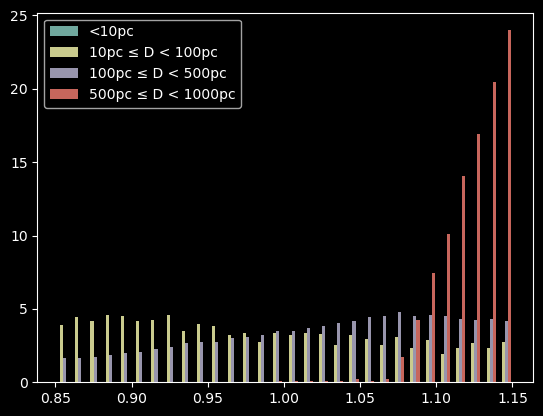

In [24]:
plt.hist(
    [massnewdis, massnewdis2, massnewdis3, massnewdis4],
    bins=30,
    label=['<10pc', '10pc ≤ D < 100pc', '100pc ≤ D < 500pc', '500pc ≤ D < 1000pc'],
    alpha=0.8
)

plt.legend()
plt.show()


plt.hist(
    [massnewdis, massnewdis2, massnewdis3, massnewdis4],
    bins=30,
    density = True,
    label=['<10pc', '10pc ≤ D < 100pc', '100pc ≤ D < 500pc', '500pc ≤ D < 1000pc'],
    alpha=0.8
)

plt.legend()
plt.show()


In [25]:
newinddis5 =  (pic_tabl2['distance'] < 100) & (pic_tabl2['Mass'] >= 0.95) & (pic_tabl2['Mass'] < 1.05) & (pic_tabl2['Teff'] >= 5540) & (pic_tabl2['Teff'] <= 5839) & (pic_tabl2['Radius'] < 0.9) & (pic_tabl2['Gmag'] < 12)

name1 = pic_tabl2['StarName', 'Mass', 'Radius', 'Teff', 'distance', 'Gmag'][newinddis5]

print(name1)

          StarName                  Mass             Radius            Teff       distance        Gmag      
                                  solMass            solRad             K            pc           mag       
---------------------------- ----------------- ----------------- ---------------- -------- -----------------
Gaia DR3 5265700621534802304 0.980592909579714  0.89750303651092 5827.25124168473  72.1143  9.14642333984375
Gaia DR3 4757024829820200704 0.965229893654007 0.874176873533068 5792.45154739888  89.0271 9.688791275024414
Gaia DR3 5499247886390351104 0.960818832717823 0.874378522896812 5766.00806429968  55.1912 8.669718742370605
Gaia DR3 4789586385623508096 0.951392860078578 0.846906931849498 5776.59476318098  92.0031 9.841035842895508
Gaia DR3 4799563663371481344 0.952335608100839 0.873850900162821 5717.22718515397  69.2592 9.203581809997559
Gaia DR3 5571053142509579648 0.963251605608022 0.873746640094586 5781.83691662433  53.0412  8.57226276397705
Gaia DR3 5561101080

https://sites.uni.edu/morgans/astro/course/Notes/section2/spectraltemps.html

In [26]:

star_names = [
    'Gaia DR3 5529801905785076992',
    'Gaia DR3 5589140589822710912',
    'Gaia DR3 4822308057854396288',
    'Gaia DR3 5600918043001487616',
    'Gaia DR3 5602096685106118272',
    'Gaia DR3 2922641274023635584',
    'Gaia DR3 5615671255659828480',
    'Gaia DR3 4829023222011088512',
    'Gaia DR3 5508988150664745856',
    'Gaia DR3 5331636478429352832',
    'Gaia DR3 5539701255640836992',
    'Gaia DR3 4802469840105263360',
    'Gaia DR3 5510893810476230144',
    'Gaia DR3 5526441690866412032',
    'Gaia DR3 5292044915839080320',
    'Gaia DR3 5321990183746655872',
    'Gaia DR3 4774543108048368512',
    'Gaia DR3 4874188960657543808',
    'Gaia DR3 2965917433220305024',
    'Gaia DR3 4881345510044485120',
    'Gaia DR3 2902205991429301888',
    'Gaia DR3 5265700621534802304',
    'Gaia DR3 4722135642226902656',
    'Gaia DR3 5481272932860894720',
    'Gaia DR3 5290382630357080320'
]

# Clean the StarName column
clean_starname = np.char.strip(pic_tabl2['StarName'].astype(str))

mask = np.isin(clean_starname, star_names)

final_tbl = pic_tabl2[mask][
    ['StarName', 'Mass', 'Radius', 'Teff', 'distance', 'Gmag', 'NSSFlag']
]

print(len(final_tbl))
print(final_tbl)


starnames2 = [ 
    'Gaia DR3 5291028181119851776',
    'Gaia DR3 5481848424118748672',
    'Gaia DR3 4729274084030162560',
    'Gaia DR3 4763906879239461632',
    'Gaia DR3 4775347916201249792',
    'Gaia DR3 4767108034327506304',
    'Gaia DR3 5485115588561239808',
    'Gaia DR3 5316675801680282880',
    'Gaia DR3 4828528063821835648',
    'Gaia DR3 4784083222550928896',
    'Gaia DR3 5514669980082910208',
    'Gaia DR3 5553647083168192512',
    'Gaia DR3 5554020058128044160',
    'Gaia DR3 5556169912598642560',
    'Gaia DR3 5568492551727378304',
    'Gaia DR3 4808165830030420352',
    'Gaia DR3 5538678297515561088',
    'Gaia DR3 5586381090520538880',
    'Gaia DR3 5546537739765203840',
    'Gaia DR3 2890222139320503040',
    'Gaia DR3 4879098280075566208',
    'Gaia DR3 5608546347283308160',
    'Gaia DR3 2898239468873596800',
    'Gaia DR3 5613359910416875392',
    'Gaia DR3 2914421428175876608'
]

# Clean the StarName column
clean_starname2 = np.char.strip(pic_tabl2['StarName'].astype(str))

mask2 = np.isin(clean_starname2, starnames2)

final_tbl2 = pic_tabl2[mask2][
    ['StarName', 'Mass', 'Radius', 'Teff', 'distance', 'Gmag', 'NSSFlag']
]

print(len(final_tbl2))
print(final_tbl2)

24
          StarName                  Mass             Radius            Teff       distance        Gmag        NSSFlag
                                  solMass            solRad             K            pc           mag                
---------------------------- ----------------- ----------------- ---------------- -------- ------------------ -------
Gaia DR3 5265700621534802304 0.980592909579714  0.89750303651092 5827.25124168473  72.1143   9.14642333984375      25
Gaia DR3 4722135642226902656  1.00761441441786 0.969757974560121 5820.04499859657   12.039  5.092834727366266       3
Gaia DR3 5292044915839080320 0.874525932035232 0.819186667291449 5378.85523281657  203.144 11.988969802856445       3
Gaia DR3 5481272932860894720  1.08375914230151  1.09819117048566  5976.2323875532  47.8832  7.702243937077247       3
Gaia DR3 5290382630357080320  1.06518064907652  1.14777493814835 5783.88959719062  93.2096  9.206395149230957       3
Gaia DR3 4774543108048368512  1.07007269960038 0.9018

In [27]:
param = np.array(pic_tabl2['Mass'])

bin_width = 0.1
bins = np.arange(0.5, 1.5 + bin_width, bin_width)

for low, high in zip(bins[:-1], bins[1:]):
    stars_in_bin = param[(pic_tabl2['Mass'] >= low) & (pic_tabl2['Mass'] < high)]
    print(f"{low:.1f}–{high:.1f}: {len(stars_in_bin)} stars")

0.5–0.6: 6419 stars
0.6–0.7: 4431 stars
0.7–0.8: 5622 stars
0.8–0.9: 9089 stars
0.9–1.0: 16141 stars
1.0–1.1: 24993 stars
1.1–1.2: 36651 stars
1.2–1.3: 41761 stars
1.3–1.4: 35359 stars
1.4–1.5: 20466 stars


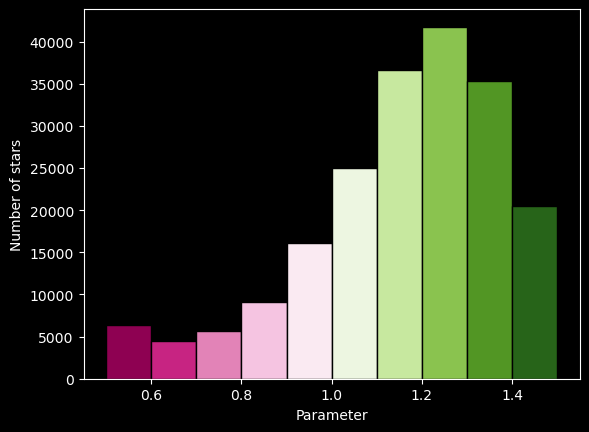

In [28]:
counts, edges = np.histogram(param, bins=bins)

# Colors for each bin
colors = plt.cm.PiYG(np.linspace(0, 1, len(counts)))

# Plot manually using bar
plt.bar(edges[:-1], counts, width=bin_width, color=colors, edgecolor='black', align='edge')

plt.xlabel('Parameter')
plt.ylabel('Number of stars')
plt.show()

0.5–0.6: 0 stars
0.6–0.7: 0 stars
0.7–0.8: 5 stars


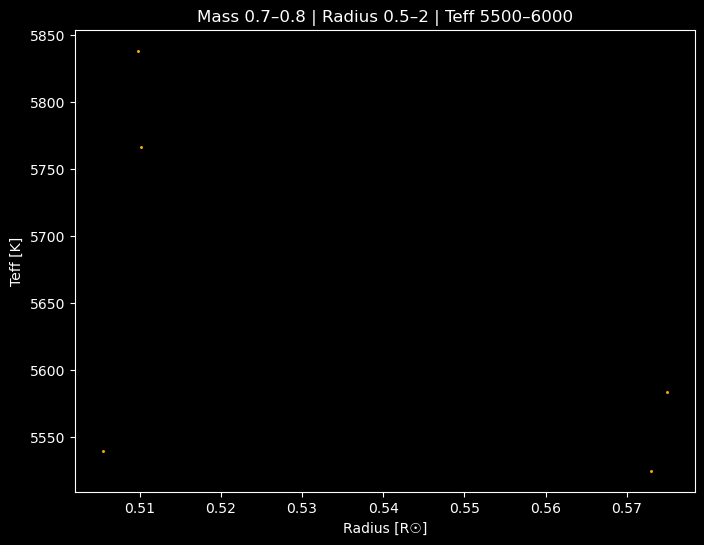

0.8–0.9: 435 stars


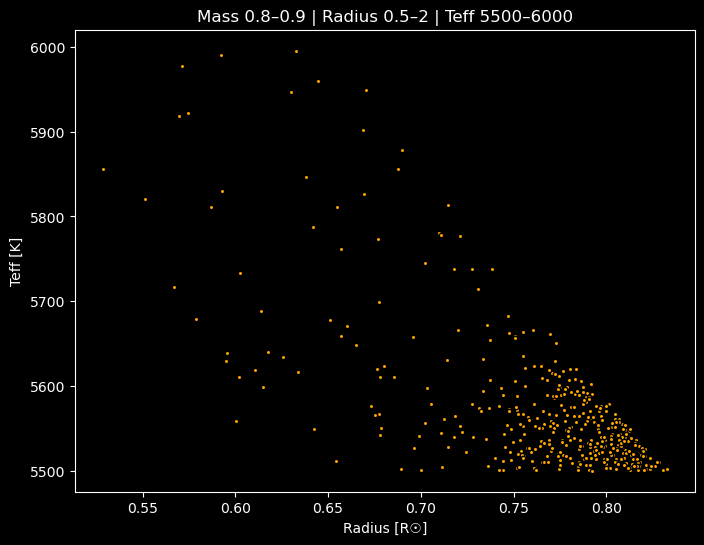

0.9–1.0: 10218 stars


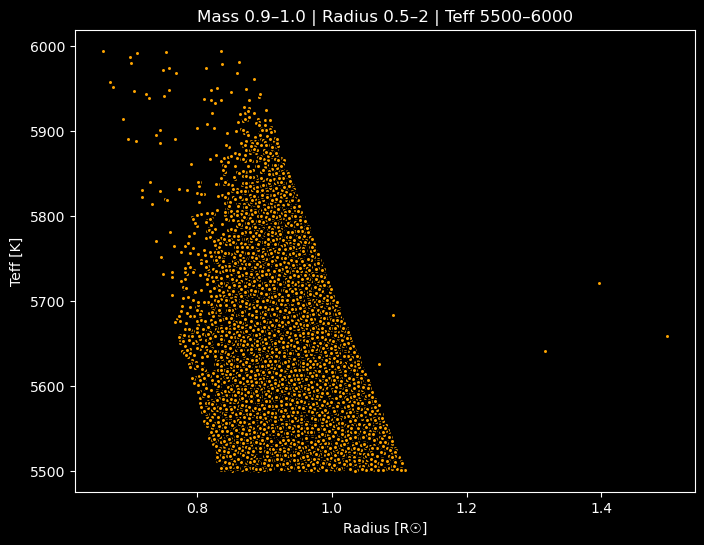

1.0–1.1: 20511 stars


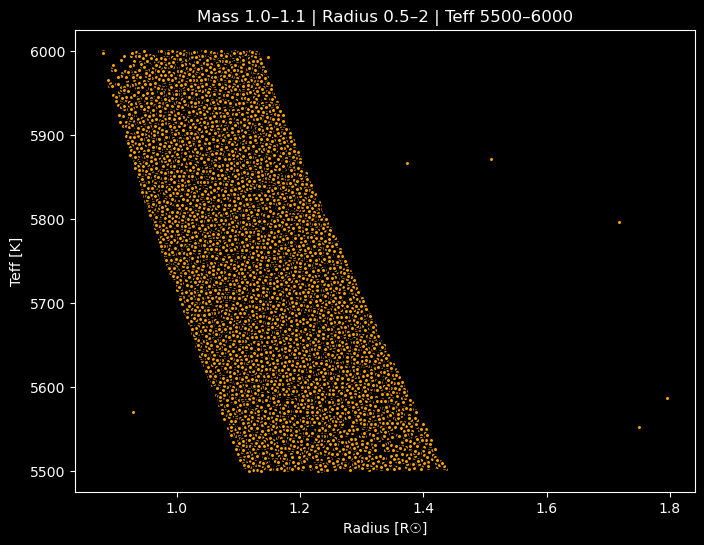

1.1–1.2: 18611 stars


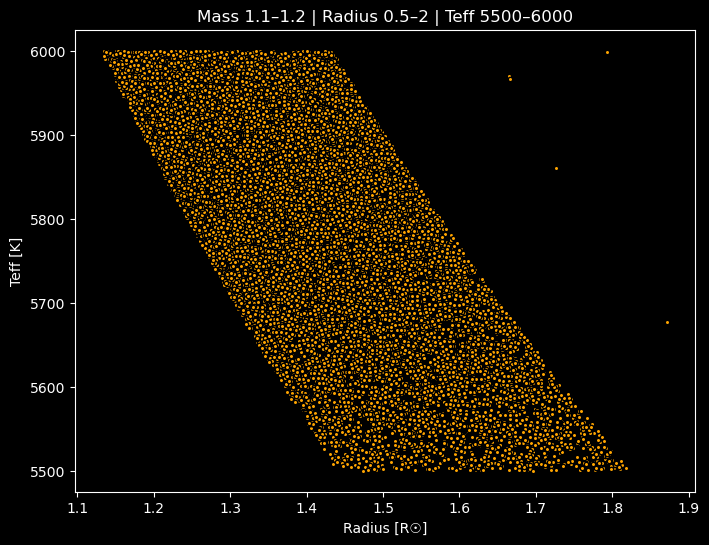

1.2–1.3: 11740 stars


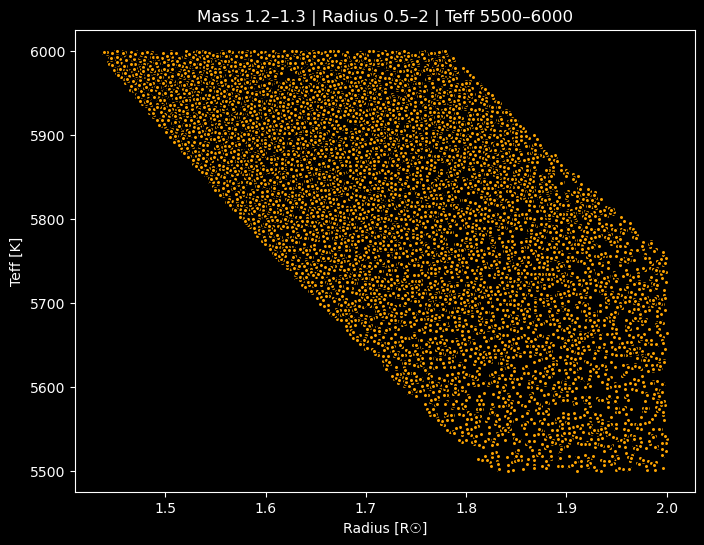

1.3–1.4: 1840 stars


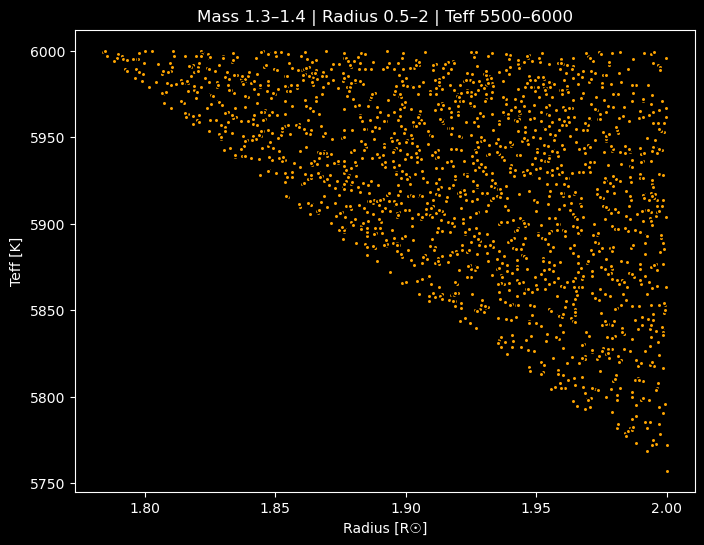

1.4–1.5: 0 stars


In [29]:
param_mass = np.array(pic_tabl2['Mass'])
param_radius = np.array(pic_tabl2['Radius'])
param_teff = np.array(pic_tabl2['Teff'])

bin_width = 0.1
bins_mass = np.arange(0.5, 1.5 + bin_width, bin_width)
radius_range = (0.5, 2)
temp_range = (5500, 6000)

for low, high in zip(bins_mass[:-1], bins_mass[1:]):
    mask = (
        (param_mass >= low) & (param_mass < high) &
        (param_radius >= radius_range[0]) & (param_radius <= radius_range[1]) &
        (param_teff >= temp_range[0]) & (param_teff <= temp_range[1])
    )
    stars_in_bin = pic_tabl2[mask]
    print(f"{low:.1f}–{high:.1f}: {len(stars_in_bin)} stars")
    if len(stars_in_bin) > 0:
        plt.figure(figsize=(8,6))
        plt.scatter(stars_in_bin['Radius'], stars_in_bin['Teff'], c='orange', edgecolor='black', marker = 'o', s = 10)
        plt.xlabel('Radius [R☉]')
        plt.ylabel('Teff [K]')
        plt.title(f"Mass {low:.1f}–{high:.1f} | Radius {radius_range[0]}–{radius_range[1]} | Teff {temp_range[0]}–{temp_range[1]}")
        #plt.gca().invert_yaxis()  # Common in stellar plots: hotter stars on top
        plt.show()

In [30]:
param_mass1 = np.array(pic_tabl2['Mass'])
param_radius1 = np.array(pic_tabl2['Radius'])
param_teff1 = np.array(pic_tabl2['Teff'])

bin_width1 = 0.1
bins_mass1 = np.arange(0.5, 1.5 + bin_width1, bin_width1)  # your Mass bins
radius_range1 = (0.5, 2)
temp_range1 = (5500, 6000)

Mass 0.5–0.6: 0 stars
Mass 0.6–0.7: 0 stars
Mass 0.7–0.8: 5 stars


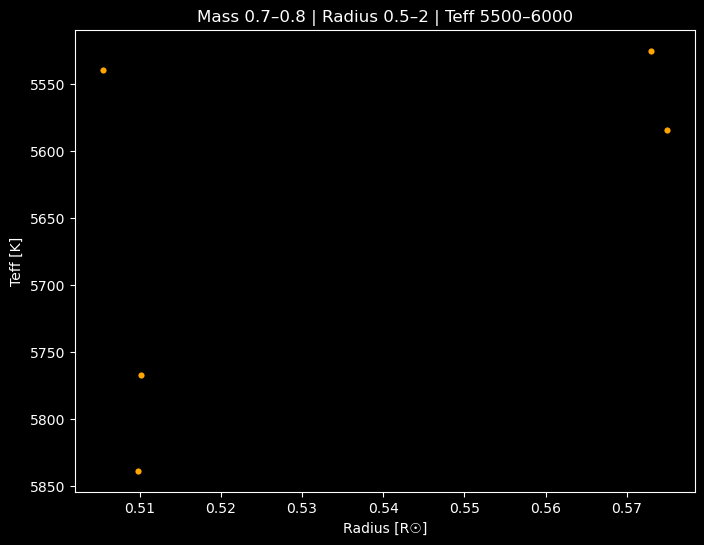

Mass 0.8–0.9: 435 stars


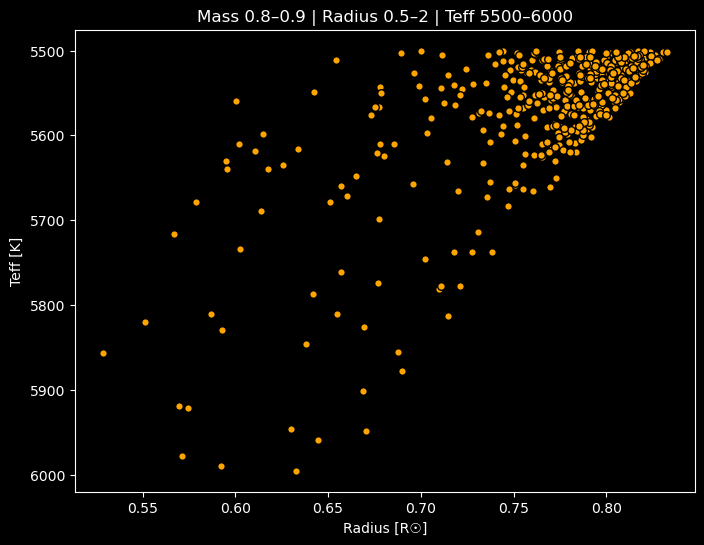

Mass 0.9–1.0: 10218 stars


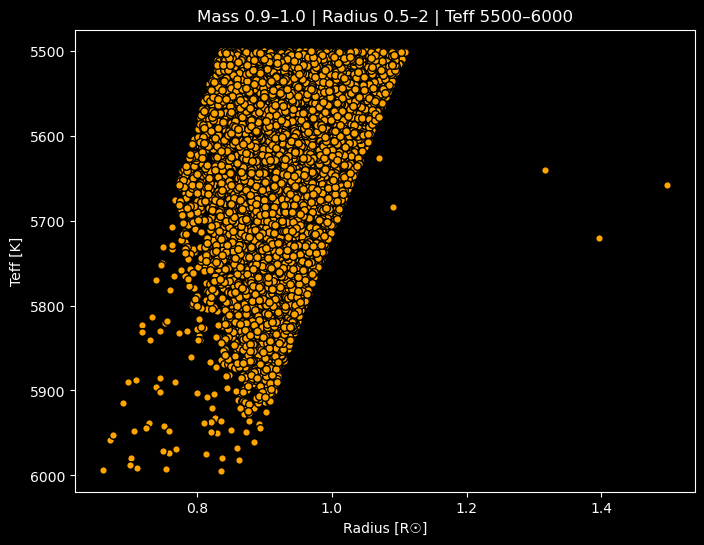

Mass 1.0–1.1: 20511 stars


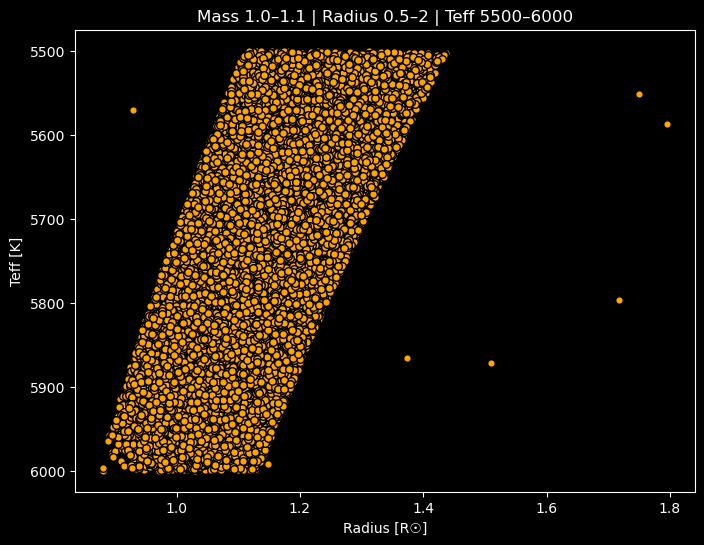

Mass 1.1–1.2: 18611 stars


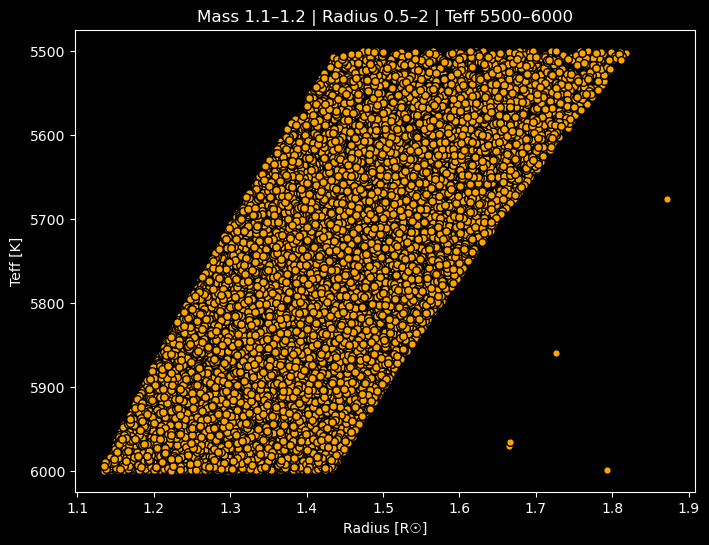

Mass 1.2–1.3: 11740 stars


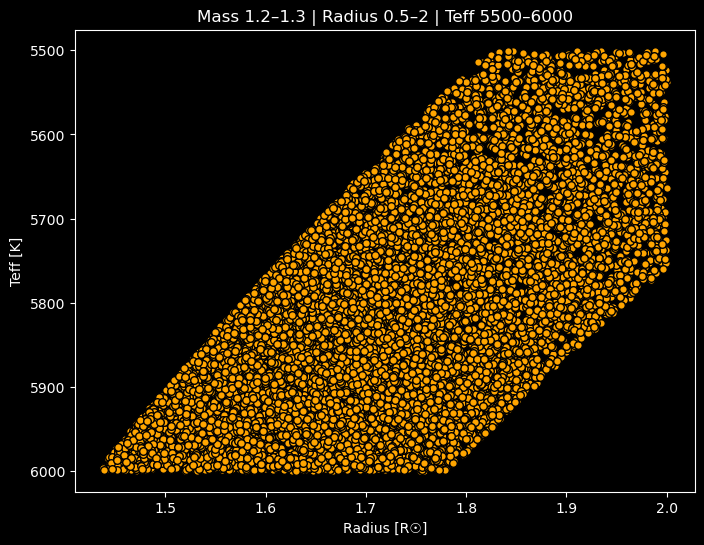

Mass 1.3–1.4: 1840 stars


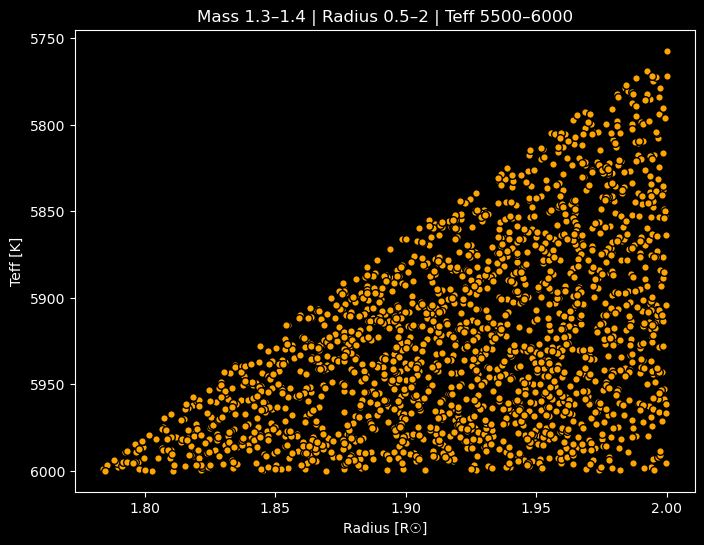

Mass 1.4–1.5: 0 stars


In [31]:
for i in range(len(bins_mass1)-1):
    low = bins_mass1[i]
    high = bins_mass1[i+1]
    
    mask = (
        (param_mass1 >= low) & (param_mass1 < high) &
        (param_radius1 >= radius_range1[0]) & (param_radius1 <= radius_range1[1]) &
        (param_teff1 >= temp_range1[0]) & (param_teff1 <= temp_range1[1])
    )
    
    stars_in_bin = pic_tabl2[mask]
    print(f"Mass {low:.1f}–{high:.1f}: {len(stars_in_bin)} stars")
    
    if len(stars_in_bin) > 0:
        fig, ax = plt.subplots(figsize=(8,6))
        sc = ax.scatter(
            stars_in_bin['Radius'], stars_in_bin['Teff'], 
            c='orange', edgecolor='black', marker='o', s=30, picker=True
        )
        ax.set_xlabel('Radius [R☉]')
        ax.set_ylabel('Teff [K]')
        ax.set_title(f"Mass {low:.1f}–{high:.1f} | Radius {radius_range1[0]}–{radius_range1[1]} | Teff {temp_range1[0]}–{temp_range1[1]}")
        ax.invert_yaxis()

    
    plt.show()